In [5]:
from PIL import Image
from collections.abc import Mapping
from itertools import product


def _square_key(square):
    flipped = square.transpose(Image.FLIP_LEFT_RIGHT)
    rotations = {
        square.tobytes(),
        square.transpose(Image.ROTATE_90).tobytes(),
        square.transpose(Image.ROTATE_180).tobytes(),
        square.transpose(Image.ROTATE_270).tobytes(),
        flipped.tobytes(),
        flipped.transpose(Image.ROTATE_90).tobytes(),
        flipped.transpose(Image.ROTATE_180).tobytes(),
        flipped.transpose(Image.ROTATE_270).tobytes(),
    }
    return b''.join(sorted(rotations))


# map pattern sequences to raw PIL data
_hash_to_bytes = {
    # binary 0 and 1 to . and #
    format(i, '04b').translate({48: 46, 49: 35}): bytes([i << 4])
    for i in range(16)
}
for l in range(3, 1, -1):
    for pattern in product('.#', repeat=l):
        pattern = ''.join(pattern)
        _hash_to_bytes[pattern] = _hash_to_bytes[pattern.ljust(4, '.')]


def _pattern_to_square(pattern, _m=_hash_to_bytes):
    parts = pattern.split('/')
    return Image.frombytes(
        '1', (len(parts), len(parts)),
        b''.join([_m[p] for p in parts])
    )


class RotationMap(Mapping):
    def __init__(self, d=None):
        self._d = {}
        if d is not None:
            self._d.update(d)

    @classmethod
    def from_lines(cls, lines, _sk=_square_key, _ps=_pattern_to_square):
        def convert_line(line):
            key, value = map(_ps, map(str.strip, line.split('=>')))
            return _sk(key), value
        return cls(map(convert_line, lines))

    def __getitem__(self, square, _sk=_square_key):
        if not isinstance(square, bytes):
            square = _sk(square)
        return self._d[square]

    def __len__(self):
        return len(self._d)
    
    def __iter__(self):
        return iter(self._d)


def transform_image(img, map, _cache=None):
    if img.size[0] <= 3:
        return map[img]
    if _cache is None:
        _cache = {}
    key = (img.size[0], img.tobytes())
    new_img = _cache.get(key)
    if new_img is None:
        step = 3 if img.size[0] % 2 else 2
        size = img.size[0] * (step + 1) // step
        parts = 3 if img.size[0] % 4 else 2
        chunksize = img.size[0] // parts
        new_img = Image.new('1', (size, size))
        for x, y in product(range(0, parts), repeat=2):
            input_x, input_y = x * chunksize, y * chunksize
            output_x, output_y = x * (size // parts), y * (size // parts)
            pattern = img.crop((input_x, input_y, input_x + chunksize, input_y + chunksize))
            new_img.paste(transform_image(pattern, map, _cache), (output_x, output_y))
        _cache[key] = new_img
    return new_img

start_image = Image.frombytes('1', (3, 3), b''.join([
    _hash_to_bytes[l.strip()] for l in '''\
        .#.
        ..#
        ###'''.splitlines()
]))

In [2]:
test_map = RotationMap.from_lines('''\
../.# => ##./#../...
.#./..#/### => #..#/..../..../#..#
'''.splitlines())
iterations = []
iteration_1 = transform_image(start_image, test_map)
iteration_2 = transform_image(iteration_1, test_map)
assert iteration_2.histogram()[-1] == 12

In [3]:
with open('inputs/day21.txt') as day21:
    map_ = RotationMap.from_lines(day21)

In [10]:
image1 = start_image
for _ in range(5):
    image1 = transform_image(image1, map_)
print('Part 1:', image1.histogram()[-1])

Part 1: 136


In [11]:
image2, cache = start_image, {}
for _ in range(18):
    image2 = transform_image(image2, map_, cache)
print('Part 2:', image2.histogram()[-1])

Part 2: 1911767


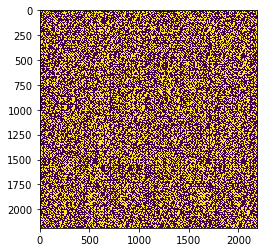

In [12]:
from matplotlib.pyplot import imshow
import numpy as np

%matplotlib inline
imshow(np.asarray(image2))